# Quantitative Risk Managemet

## Volatility

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
sys.path.append('../CODE')  # Adjust the path as necessary


from IPython.display import clear_output
'''
!rm -r {'QuantRiskManagement'}

!git clone https://github.com/Lolillosky/QuantRiskManagement.git

import sys
sys.modules.pop
sys.path.insert(0,'QuantRiskManagement/CODE')
'''
clear_output()


In [34]:
import Option_formulas
import pytorch_option_formulas

In [4]:
risk_factors = pd.read_csv('../DATA/Histdata_equity.csv',index_col=0,parse_dates=True)

risk_factors['Vol A'] /= 100
risk_factors['Vol B'] /= 100
risk_factors['Vol C'] /= 100

risk_factors.head()

,Spot A,Vol A,Spot B,Vol B,Spot C,Vol C
Dates,,,,,,
2010-01-01,7.526,0.37458,125.0310,0.23275,41.67,0.35088
2010-01-04,7.643,0.37428,126.5115,0.23198,42.85,0.34045
2010-01-05,7.656,0.38004,124.9832,0.23318,43.68,0.33323
2010-01-06,7.535,0.36918,124.1713,0.22726,43.92,0.31933
2010-01-07,7.521,0.37071,123.7415,0.22640,44.79,0.31422


In [5]:
class Portfolio_Delta_NPV_Calculator:

    def __init__(self, notionals ,contracts):
        self.contracts = contracts
        self.notionals = notionals

    def value(self,t ,risk_factors):

        portfolio_value = np.zeros(risk_factors.shape[0])
        component_values = np.zeros((risk_factors.shape[0],len(self.contracts)))

        for i, (n, c) in enumerate(zip(self.notionals,self.contracts)):
            
            component_values[:,i] = c(t,risk_factors)
            portfolio_value += n*component_values[:,i]

        return portfolio_value, component_values
    
    def compute_scenarios_pl(self, risk_factors_base_scenario, delta_t, risk_factors_shocked):
        
        portfolio_value_base_scenario, component_values_base_scenario = self.value(0,risk_factors_base_scenario)

        portfolio_value_shocked, component_values_shocked  = self.value(delta_t,risk_factors_shocked)

        return portfolio_value_shocked - portfolio_value_base_scenario, component_values_shocked - component_values_base_scenario

        

In [6]:
horizon = 10

portfolio = [lambda t,risk_factors: risk_factors[:,0],
            lambda t,risk_factors: Option_formulas.BlackScholes(risk_factors[:,0], 125,0.5-t,0.01, 0.0, risk_factors[:,1], False),
            lambda t,risk_factors: risk_factors[:,2],
            lambda t,risk_factors: Option_formulas.BlackScholes(risk_factors[:,2], 150,0.5-t,0.01, 0.0, risk_factors[:,3], True),
            lambda t,risk_factors: Option_formulas.BlackScholes(risk_factors[:,4], 135,0.5-t,0.01, 0.0, risk_factors[:,5], True)]

notionals = [1,1,1,-1,-1]



base_scenario = risk_factors.values[-1].reshape(1,-1)


risk_factors_shocked = base_scenario* risk_factors.values[10:]/risk_factors.values[:-10]
            

portfolio_calculator = Portfolio_Delta_NPV_Calculator(notionals,portfolio) 


portfolio_pl, constituents_pl = portfolio_calculator.compute_scenarios_pl(base_scenario,0,risk_factors_shocked)

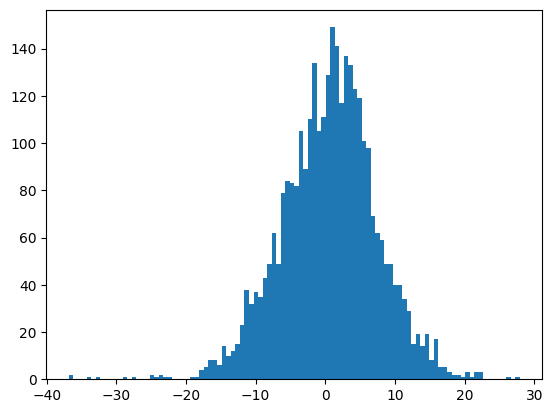

In [7]:
plt.hist(portfolio_pl,bins=100);

In [8]:
np.std(portfolio_pl,ddof=1)

6.853310610517585

In [9]:
C = np.cov(constituents_pl.T)
w = np.array(notionals).reshape(-1,1)

std = np.sqrt(w.T @ C @ w)

std

array([[6.85331061]])

In [55]:
std -np.std(portfolio_pl,ddof=1)

array([[8.8817842e-16]])

In [10]:
import torch

In [29]:
C_torch = torch.tensor(C, requires_grad=True,dtype=torch.float64)
w_torch = torch.tensor(w, requires_grad=True, dtype=torch.float64)

std_torch = torch.sqrt(w_torch.T @ C_torch @ w_torch)[0,0]


std_torch.backward()

print(w_torch*w_torch.grad / std_torch) 

print(np.sum(w_torch.detach().numpy()*w_torch.grad.numpy())/ std_torch )

tensor([[ 0.9616],
        [-0.2876],
        [ 0.4907],
        [-0.1872],
        [ 0.0224]], dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(1.0000, dtype=torch.float64, grad_fn=<MulBackward0>)


In [32]:
w_torch.grad

tensor([[ 6.5899],
        [-1.9709],
        [ 3.3632],
        [ 1.2826],
        [-0.1537]], dtype=torch.float64)

In [33]:
C_torch @ w_torch / std_torch

tensor([[ 6.5899],
        [-1.9709],
        [ 3.3632],
        [ 1.2826],
        [-0.1537]], dtype=torch.float64, grad_fn=<DivBackward0>)

In [69]:
portfolio_torch = [lambda risk_factors: risk_factors[:,0],
            lambda risk_factors: pytorch_option_formulas.BlackScholes(risk_factors[:,0], torch.tensor(125.0),
                torch.tensor(0.5), torch.tensor(0.01), torch.tensor(0.0), risk_factors[:,1], False),
            lambda risk_factors: risk_factors[:,2],
            lambda risk_factors: pytorch_option_formulas.BlackScholes(risk_factors[:,2], torch.tensor(150.0),
                torch.tensor(0.5), torch.tensor(0.01), torch.tensor(0.0), risk_factors[:,3], True),
            lambda risk_factors: pytorch_option_formulas.BlackScholes(risk_factors[:,4], torch.tensor(135.0),
                torch.tensor(0.5), torch.tensor(0.01), torch.tensor(0.0), risk_factors[:,5], True)]

base_scenario_torch = torch.tensor(base_scenario, requires_grad=True,dtype=torch.float64)
w_torch = torch.tensor(w, requires_grad=True, dtype=torch.float64)

base_scenario_NPV_constituents = [p(base_scenario_torch) for p in portfolio_torch]

base_scenario_NPV = torch.sum(w_torch * torch.stack(base_scenario_NPV_constituents))

base_scenario_NPV.backward()

sens = base_scenario_torch.grad.numpy()

sens


array([[  0.73611714,  32.57275946,   0.49455613, -41.54023273,
         -0.5013736 , -37.09524587]])

In [74]:
npv_sens = np.sum((risk_factors_shocked - base_scenario)* sens, axis = 1)

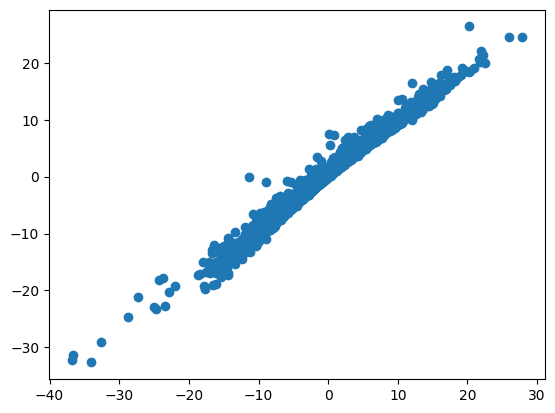

In [75]:
plt.plot(portfolio_pl, npv_sens, 'o')

In [76]:
np.std(portfolio_pl,ddof=1), np.std(npv_sens,ddof=1)

(6.853310610517585, 6.681837727183785)

In [77]:
df = pd.DataFrame({'NPV':portfolio_pl, 'Sens':npv_sens})

<Axes: >

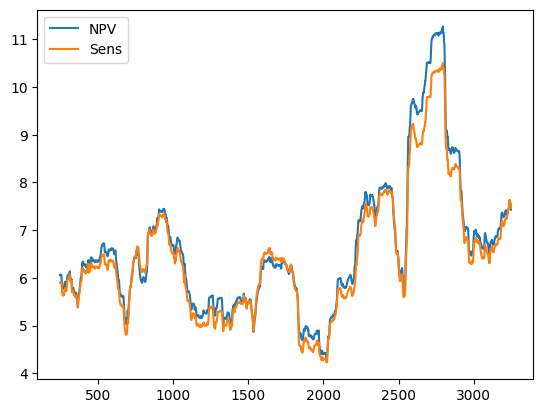

In [78]:
df.rolling(250).std().plot()